In [1]:
# import library necessary

import pandas as pd
import numpy as np
import os
import re, string, unicodedata
import matplotlib.pyplot as plt
import seaborn
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
import nltk

# Zad 
Pobierz dane ze strony:
https://www.kaggle.com/c/sa-emotions/overview

In [2]:
df = pd.read_csv(os.path.join(os.getcwd(), 'data', 'train_data.csv')) 
df.shape
df.head()

,sentiment,content
0,empty,@tiffanylue i know i was listenin to bad habi...
1,sadness,Layin n bed with a headache ughhhh...waitin o...
2,sadness,Funeral ceremony...gloomy friday...
3,enthusiasm,wants to hang out with friends SOON!
4,neutral,@dannycastillo We want to trade with someone w...


In [3]:
# os.path.join(os.getcwd(), 'data', 'train_data.csv')

In [4]:
df = df[:1000] 

df.isnull().sum()

sentiment    0
content      0
dtype: int64

# Zad
Zobacz ile jest klas.

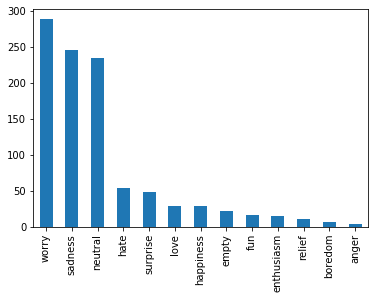

In [5]:
sentiment_freq = df['sentiment'].value_counts()
fig, ax = plt.subplots()

sentiment_freq.plot(ax=ax, kind='bar')

# Zad

Podzielmy atrybuty na część 
* objaśniającą $X$
* objaśnianą $y$

In [6]:
X = df.drop(['sentiment'], axis=1)
y = df['sentiment'].values
print(X.shape)
print(y.shape)

(1000, 1)
(1000,)


# Zad 
Przyjrzyjmy się $y$. Musi to być kolumna numeryczna z labealmi.

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html

In [7]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

print("X.shape: {} y.shape: {}".format(X.shape, y.shape))

X.shape: (1000, 1) y.shape: (1000,)


In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

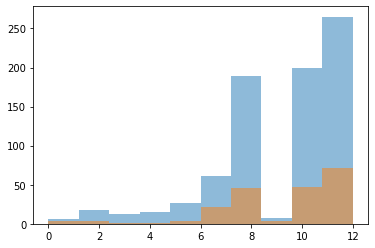

In [9]:
plt.hist(y_train, alpha=0.5)
plt.hist(y_test, alpha=0.5)
plt.show()

# Zad
Zbudujmy **pipeline** dla atrybutu "content":

 * usuń adresy stron interntowych
 * usuń słowa zaczynające się od "@"
 * usuń punktory
 * usuń liczby (lub zamień je na jeden token "<NUMBER\>")
 * zamień wszystkie słowa na zaczynające się z małej litery
 * wygeneruj reprezentację    
 * Tfidf

In [10]:
from sklearn.base import BaseEstimator, TransformerMixin

# A class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return X[self.attribute_names]

In [11]:
# import library necessary

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
# import nltk

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string 

# import enchant
# eng_dict = enchant.Dict("en_US")
words_to_save = ['<EOS>', '<BOS>']


# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
def remove_urls(text):
    txt = re.sub(r'pic\.twitter\.com.*?( |$)', '', text)
    txt = re.sub(r'http.+?\xa0', '', txt)
    return re.sub(r'http.+?( |$)', '', txt)

def remove_marks(text):
    return re.sub(r'@ ?.*?( |$)', '', text)
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words


def sen2token(sentence):
    sentence = remove_urls(sentence)
    sentence = remove_marks(sentence)
    return word_tokenize(sentence)


def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        if word in words_to_save:
            new_words.append(word)
            continue
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def add_tags(words):
    new_words = []
    for word_id, word in enumerate(words):
        if word in ['...', '.', '!', '?']:
            new_words.append('<EOS>')
            new_words.append('<BOS>')
        else:
            new_words.append(word)
    new_words.insert(0, '<BOS>')
    if new_words[-1] == '<BOS>':
        return new_words[:-1]
    return new_words




def to_lower(words):
    return [w.lower() for w in words]

def remove_nummbers(words):
    return [w for w in words if not w.isdigit()]

def stemming_tokenizer(words):
    words = sen2token(words)
    words = remove_non_ascii(words)
    words = to_lower(words)     
#     words = remove_punctuation(words)
#     words = remove_no_english(words)    
    words = remove_nummbers(words)

    
    stemmer = PorterStemmer()
    return [stemmer.stem(w) for w in words]

#preprocessor działa na całym dokumencie
def my_preprocessing(word):
    return word

tfidf_vectorizer = TfidfVectorizer(preprocessor = my_preprocessing, 
                tokenizer=stemming_tokenizer, 
                stop_words=stopwords.words('english') + list(string.punctuation))

# tfidf_vectorizer.fit(X)
# # print( tfidf_vectorizer.vocabulary_ )
# tfidf_matrix = tfidf_vectorizer.transform(X)
# # print(tfidf_matrix.todense())

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin



class ToListEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return X.values.T.tolist()[0]


preprocess_pipeline = Pipeline([
        ("select_cat", DataFrameSelector(['content'])),
        ("to_numpy", ToListEncoder()),
        ("dictionary_encoder", tfidf_vectorizer),
    ])

X_tr = preprocess_pipeline.fit_transform(X_train)
X_tr
X_tr.todense().shape

C:\Users\admin\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:391: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", '``', 'abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'ha', 'hi', 'might', 'must', "n't", 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'wa', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


(800, 2203)

In [14]:
# sen2token()
print(df.content.values[0])
sen2token(df.content.values[0])

@tiffanylue i know  i was listenin to bad habit earlier and i started freakin at his part =[


['i',
 'know',
 'i',
 'was',
 'listenin',
 'to',
 'bad',
 'habit',
 'earlier',
 'and',
 'i',
 'started',
 'freakin',
 'at',
 'his',
 'part',
 '=',
 '[']

In [15]:
# sen2token()
print(df.content.values[7])
sen2token(df.content.values[7])

Hmmm. http://www.djhero.com/ is down


['Hmmm', '.', 'is', 'down']

# Zad

Robimy StratifiedKFold i znajdujemy optymalne parametry dla


* MultinomialNB (bez redukcji wymiarowości)
* LogisticRegression
* LinearSVC
* SVC
* KNeighborsClassifier
* DecisionTreeClassifier
* RandomForestClassifier
* BaggingClassifier
* ExtraTreesClassifier
* AdaBoostClassifier
* GradientBoostingClassifier
* VotingClassifier
* xgboost.XGBClassifier

In [22]:
from sklearn.model_selection import StratifiedKFold

seed=123
kfold = StratifiedKFold(n_splits=5)

In [23]:
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
pipe = Pipeline([
    ('preprocessing', preprocess_pipeline), 
    ('classifier', LinearSVC())])


param_grid = {
            'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]
}

grid_1 = GridSearchCV(pipe, param_grid, cv=kfold)

grid_1.fit(X_train, y_train)
grid_1.best_params_

C:\Users\admin\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:391: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", '``', 'abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'ha', 'hi', 'might', 'must', "n't", 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'wa', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\admin\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:391: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", '``', 'abov', 'ani', 'becaus', 'befor', '

C:\Users\admin\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:391: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", '``', 'abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'ha', 'hi', 'might', 'must', "n't", 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'wa', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\admin\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:391: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", '``', 'abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'ha', 'hi', 'might', 'must', "n't", 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'wa', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent)

{'classifier__C': 0.1}

In [24]:
from sklearn import  metrics


models = []
models.append(('SVM linear', grid_1.best_estimator_))



precision_score = []
recall_score = []
f1_score = []
accuracy_score = []
for name, model in models:
    print(name)
    print("precision_score: {}".format(metrics.precision_score(y_test, model.predict(X_test), average='weighted') ))
    print("recall_score: {}".format( metrics.recall_score(y_test, model.predict(X_test), average='weighted') ))
    print("f1_score: {}".format( metrics.f1_score(y_test, model.predict(X_test), average='weighted') ))
    print("accuracy_score: {}".format( metrics.accuracy_score(y_test, model.predict(X_test)) ))
    precision_score.append(metrics.precision_score(y_test, model.predict(X_test), average='weighted'))
    recall_score.append(metrics.recall_score(y_test, model.predict(X_test), average='weighted'))
    f1_score.append( metrics.f1_score(y_test, model.predict(X_test), average='weighted'))
    accuracy_score.append(metrics.accuracy_score(y_test, model.predict(X_test)))

SVM linear
precision_score: 0.2554543650793651


C:\Users\admin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


recall_score: 0.335
f1_score: 0.2890102874043593
accuracy_score: 0.335


C:\Users\admin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [25]:
import pandas as pd
d = {'precision_score': precision_score, 
     'recall_score': recall_score, 
     'f1_score': f1_score,
     'accuracy_score' : accuracy_score
    }
df = pd.DataFrame(data=d)
df.insert(loc=0, column='Method', value=['SVM linear'])
df

,Method,precision_score,recall_score,f1_score,accuracy_score
0,SVM linear,0.255454,0.335,0.28901,0.335
